In [1]:
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.layers import Input, Dense, Dropout, concatenate, UpSampling1D, Flatten, MaxPooling1D, BatchNormalization, average,Convolution2D,MaxPooling2D,UpSampling2D,Conv1D,LeakyReLU,add
from keras.models import Model
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler
import scipy.io
import numpy as np
from keras import backend as K
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

F:\anaconda_intiall352\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def huber_loss(y_true, y_pred, clip_delta=1.3):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

def huber_loss_mean(y_true, y_pred, clip_delta=1.3):
  return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

def yc_patch(A,l1,l2,o1,o2):

    n1,n2=np.shape(A);
    tmp=np.mod(n1-l1,o1)
    if tmp!=0:
        print(np.shape(A), o1-tmp, n2)
        A=np.concatenate([A,np.zeros((o1-tmp,n2))],axis=0)

    tmp=np.mod(n2-l2,o2);
    if tmp!=0:
        A=np.concatenate([A,np.zeros((A.shape[0],o2-tmp))],axis=-1);


    N1,N2 = np.shape(A)
    X=[]
    for i1 in range (0,N1-l1+1, o1):
        for i2 in range (0,N2-l2+1,o2):
            tmp=np.reshape(A[i1:i1+l1,i2:i2+l2],(l1*l2,1));
            X.append(tmp);
    X = np.array(X)
    return X[:,:,0]

def yc_patch_inv(X1, n1, n2, l1, l2, o1, o2):
    tmp1 = np.mod(n1 - l1, o1)
    tmp2 = np.mod(n2 - l2, o2)
    if (tmp1 != 0) and (tmp2 != 0):
        A = np.zeros((n1 + o1 - tmp1, n2 + o2 - tmp2))
        mask = np.zeros((n1 + o1 - tmp1, n2 + o2 - tmp2))

    if (tmp1 != 0) and (tmp2 == 0):
        A = np.zeros((n1 + o1 - tmp1, n2))
        mask = np.zeros((n1 + o1 - tmp1, n2))

    if (tmp1 == 0) and (tmp2 != 0):
        A = np.zeros((n1, n2 + o2 - tmp2))
        mask = np.zeros((n1, n2 + o2 - tmp2))

    if (tmp1 == 0) and (tmp2 == 0):
        A = np.zeros((n1, n2))
        mask = np.zeros((n1, n2))

    N1, N2 = np.shape(A)
    ids = 0
    for i1 in range(0, N1 - l1 + 1, o1):
        for i2 in range(0, N2 - l2 + 1, o2):
            # print(i1,i2)
            #       [i1,i2,ids]
            A[i1:i1 + l1, i2:i2 + l2] = A[i1:i1 + l1, i2:i2 + l2] + np.reshape(X1[:, ids], (l1, l2))
            mask[i1:i1 + l1, i2:i2 + l2] = mask[i1:i1 + l1, i2:i2 + l2] + np.ones((l1, l2))
            ids = ids + 1

    A = A / mask;
    A = A[0:n1, 0:n2]
    return A


def cseis():
    from matplotlib.colors import ListedColormap
    import numpy as np
    seis=np.concatenate(
(np.concatenate((0.5*np.ones([1,40]),np.expand_dims(np.linspace(0.5,1,88),axis=1).transpose(),np.expand_dims(np.linspace(1,0,88),axis=1).transpose(),np.zeros([1,40])),axis=1).transpose(),
np.concatenate((0.25*np.ones([1,40]),np.expand_dims(np.linspace(0.25,1,88),axis=1).transpose(),np.expand_dims(np.linspace(1,0,88),axis=1).transpose(),np.zeros([1,40])),axis=1).transpose(),
np.concatenate((np.zeros([1,40]),np.expand_dims(np.linspace(0,1,88),axis=1).transpose(),np.expand_dims(np.linspace(1,0,88),axis=1).transpose(),np.zeros([1,40])),axis=1).transpose()),axis=1)
    return ListedColormap(seis)

In [3]:
model = load_model('best_model_2dfield_our.h5',custom_objects={'tf': tf,'huber_loss_mean':huber_loss_mean})

model.summary()
mat = scipy.io.loadmat(r'./Data/Field2D/2dfield-n.mat')
dn = mat['dn']

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2304)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           147520      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           147520      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64)           0           dense_1[0][0]                    
____________________________________________________________________________________________

In [16]:
w1=48
w2=48
z1=1
z2=1

n1,n2 = np.shape(dn)
dataNoisy = yc_patch(dn, w1, w2, z1, z2)
dataNoisy = np.reshape(dataNoisy,(dataNoisy.shape[0], w1*w2))
dataNoisy = np.array(dataNoisy)
ind1=np.random.RandomState(seed=42).permutation(len(dataNoisy))
ind = np.random.permutation(len(dataNoisy))
dataNoisy = dataNoisy[ind1]
print(dataNoisy.shape)


(43681, 2304)


In [17]:
### predict three different levels. see Figure 24

dense1_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_1').output) # predict the output of the first dense layer
dense1 = dense1_layer_model.predict(dataNoisy)
print('dense_1.shape:',dense1.shape)

layer1_layer_model = Model(inputs=model.input,outputs=model.get_layer('dropout_1').output)  # predict the output of the first FE block
layer1 = layer1_layer_model.predict(dataNoisy)
print('layer_1.shape:',layer1.shape)

block1_layer_model = Model(inputs=model.input,outputs=model.get_layer('lambda_2').output)  # predict the output of the first MA block
block1 = block1_layer_model.predict(dataNoisy)
print('block_1.shape:',block1.shape)


dense_1.shape: (43681, 64)
layer_1.shape: (43681, 64)
block_1.shape: (43681, 64)


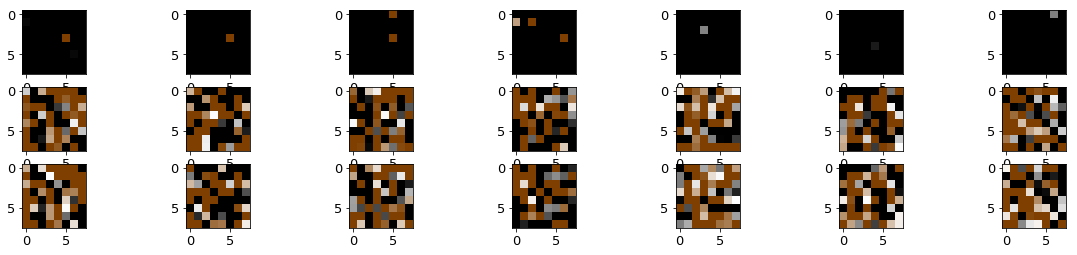

In [19]:
l=7
plt.figure(figsize=(20,4))
for i in range(l):
    ax1 = plt.subplot(3,l,i+1)
    plt.imshow(dense1[i].reshape(8,8),cmap=cseis(),clim=(-0.1,0.1))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('',size=13)
    plt.ylabel('',size=13)   
    
    ax2 = plt.subplot(3,l,i+1+l)
    plt.imshow(layer1[i].reshape(8,8),cmap=cseis(),clim=(-0.1,0.1))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('',size=13)
    plt.ylabel('',size=13) 
    
    ax3 = plt.subplot(3,l,i+1+2*l)
    plt.imshow(block1[i].reshape(8,8),cmap=cseis(),clim=(-0.1,0.1))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('',size=13)
    plt.ylabel('',size=13) 

In [21]:
### outpot three different encoders. see Figure 29

INPUT_SIZE1 = dataNoisy.shape[0]
INPUT_SIZE2 = dataNoisy.shape[1]

input_img = Input(shape=(INPUT_SIZE2,))

# See the model.summary()
#lambda_2 denotes the outpu of the first encoder,
#lambda_4 denotes the outpu of the second encoder
#lambda_6 denotes the outpu of the second encoder

### load the first encoder
layer_model1 = Model(inputs=model.input,outputs=model.get_layer('lambda_2').output) 
model_in1 = layer_model1(input_img)
layer_model1.summary()

de1 = Dense(INPUT_SIZE2, activation='linear')(model_in1)

model1 = Model(inputs=input_img, outputs=de1)
model1.summary()
model1.compile(optimizer='adam', loss=huber_loss_mean)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2304)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           147520      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           147520      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64)           0           dense_1[0][0]                    
____________________________________________________________________________________________

In [22]:
def lr_schedule(epoch):
    initial_lr = 1e-3

    if epoch <= 20:
        lr = initial_lr
    elif epoch <= 40:
        lr = initial_lr / 2
    elif epoch <= 60:
        lr = 3e-4
    elif epoch <= 80:
        lr = initial_lr / 10
    else:
        lr = initial_lr / 20
   # print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.3),
                                   cooldown=0,

                                   patience=5,
                                   min_lr=0.5e-5,
                                   monitor='val_loss')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model_2dfield_our_test_layer.h5', monitor='val_loss', mode='min', save_best_only=True)

batch = 128

### retrain the model a first time
history1 = model1.fit(dataNoisy, dataNoisy, verbose=2,epochs=100, batch_size=batch, shuffle="batch", callbacks=[lr_reducer,es, mc,lr_scheduler],
                          validation_split=0.2)

Train on 34944 samples, validate on 8737 samples
Epoch 1/100
 - 10s - loss: 0.0036 - val_loss: 0.0032
Epoch 2/100
 - 5s - loss: 0.0032 - val_loss: 0.0032
Epoch 3/100
 - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 4/100
 - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 5/100
 - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 6/100
 - 6s - loss: 0.0032 - val_loss: 0.0031
Epoch 7/100
 - 6s - loss: 0.0032 - val_loss: 0.0031
Epoch 8/100
 - 6s - loss: 0.0032 - val_loss: 0.0031
Epoch 9/100
 - 6s - loss: 0.0032 - val_loss: 0.0031
Epoch 10/100
 - 6s - loss: 0.0032 - val_loss: 0.0031
Epoch 11/100
 - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 12/100
 - 6s - loss: 0.0032 - val_loss: 0.0031
Epoch 13/100
 - 6s - loss: 0.0032 - val_loss: 0.0031
Epoch 14/100
 - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 15/100
 - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 16/100
 - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 17/100
 - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 18/100
 - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch

In [23]:
out1 = model1.predict(dataNoisy)
#ind1=np.random.RandomState(seed=42).permutation(len(out1))
#out1 = out1[ind1]
print("out1.shape is:",out1.shape)

out1.shape is: (43681, 2304)


In [24]:
### load the second encoder
layer_model2 = Model(inputs=model.input,outputs=model.get_layer('lambda_4').output) 
model_in2 = layer_model2(input_img)
layer_model2.summary()

de2 = Dense(INPUT_SIZE2, activation='linear')(model_in2)

model2 = Model(inputs=input_img, outputs=de2)
model2.summary()
model2.compile(optimizer='adam', loss=huber_loss_mean)

### retrain the model a second time

history2 = model2.fit(dataNoisy, dataNoisy, verbose=2,epochs=100, batch_size=batch, shuffle="batch", callbacks=[lr_reducer,es, mc,lr_scheduler],
                          validation_split=0.2)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2304)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           147520      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           147520      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64)           0           dense_1[0][0]                    
____________________________________________________________________________________________

Train on 34944 samples, validate on 8737 samples
Epoch 1/100
 - 10s - loss: 0.0041 - val_loss: 0.0035
Epoch 2/100
 - 6s - loss: 0.0035 - val_loss: 0.0034
Epoch 3/100
 - 6s - loss: 0.0034 - val_loss: 0.0033
Epoch 4/100
 - 6s - loss: 0.0034 - val_loss: 0.0033
Epoch 5/100
 - 6s - loss: 0.0034 - val_loss: 0.0033
Epoch 6/100
 - 6s - loss: 0.0034 - val_loss: 0.0033
Epoch 7/100
 - 8s - loss: 0.0034 - val_loss: 0.0033
Epoch 8/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch 9/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch 10/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch 11/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch 12/100
 - 8s - loss: 0.0034 - val_loss: 0.0033
Epoch 13/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch 14/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch 15/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch 16/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch 17/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch 18/100
 - 7s - loss: 0.0034 - val_loss: 0.0033
Epoch

In [25]:
out2 = model2.predict(dataNoisy) 
#ind2=np.random.RandomState(seed=42).permutation(len(out2))
#out2 = out2[ind2]
print("out2.shape is:",out2.shape)

out2.shape is: (43681, 2304)


In [27]:

### load the third encoder
layer_model3 = Model(inputs=model.input,outputs=model.get_layer('lambda_6').output) 
model_in3 = layer_model3(input_img)
layer_model3.summary()

de3 = Dense(INPUT_SIZE2, activation='linear')(model_in3)

model3 = Model(inputs=input_img, outputs=de3)
model3.summary()
model3.compile(optimizer='adam', loss=huber_loss_mean)

history3 = model3.fit(dataNoisy, dataNoisy, verbose=2,epochs=100, batch_size=batch, shuffle="batch", callbacks=[lr_reducer,es, mc,lr_scheduler],
                          validation_split=0.2)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2304)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           147520      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           147520      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64)           0           dense_1[0][0]                    
___________________________________________________________________________________________

Train on 34944 samples, validate on 8737 samples
Epoch 1/100
 - 13s - loss: 0.0041 - val_loss: 0.0036
Epoch 2/100
 - 8s - loss: 0.0036 - val_loss: 0.0035
Epoch 3/100
 - 8s - loss: 0.0036 - val_loss: 0.0035
Epoch 4/100
 - 8s - loss: 0.0036 - val_loss: 0.0035
Epoch 5/100
 - 8s - loss: 0.0035 - val_loss: 0.0035
Epoch 6/100
 - 8s - loss: 0.0035 - val_loss: 0.0035
Epoch 7/100
 - 9s - loss: 0.0035 - val_loss: 0.0034
Epoch 8/100
 - 8s - loss: 0.0035 - val_loss: 0.0035
Epoch 9/100
 - 8s - loss: 0.0035 - val_loss: 0.0034
Epoch 10/100
 - 8s - loss: 0.0035 - val_loss: 0.0034
Epoch 11/100
 - 8s - loss: 0.0035 - val_loss: 0.0034
Epoch 12/100
 - 8s - loss: 0.0035 - val_loss: 0.0034
Epoch 13/100
 - 8s - loss: 0.0035 - val_loss: 0.0034
Epoch 14/100
 - 8s - loss: 0.0035 - val_loss: 0.0034
Epoch 15/100
 - 8s - loss: 0.0035 - val_loss: 0.0034
Epoch 16/100
 - 8s - loss: 0.0035 - val_loss: 0.0034
Epoch 17/100
 - 8s - loss: 0.0035 - val_loss: 0.0034
Epoch 18/100
 - 9s - loss: 0.0035 - val_loss: 0.0034
Epoch

In [28]:
out3 = model3.predict(dataNoisy) 
#ind3=np.random.RandomState(seed=42).permutation(len(out3))
#out3 = out3[ind3]
print("out3.shape is:",out3.shape)

out3.shape is: (43681, 2304)


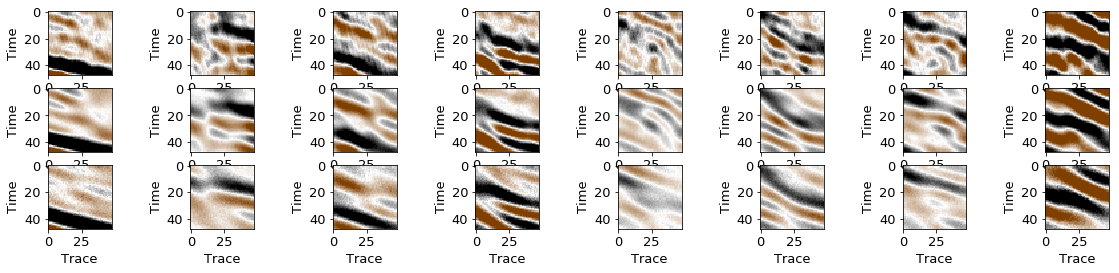

In [29]:
n = 8  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax1 = plt.subplot(3, n, i + 1)
    plt.imshow(out1[i].reshape(48, 48),cmap=cseis(),clim=(-0.1,0.1));
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Trace',size=13)
    plt.ylabel('Time',size=13)

    ax2 = plt.subplot(3, n, i + 1 +n)
    plt.imshow(out2[i].reshape(48, 48),cmap=cseis(),clim=(-0.1,0.1));
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Trace',size=13)
    plt.ylabel('Time',size=13)
    
    ax3 = plt.subplot(3, n, i + 1 +2*n)
    plt.imshow(out3[i].reshape(48, 48),cmap=cseis(),clim=(-0.1,0.1));
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Trace',size=13)
    plt.ylabel('Time',size=13)
#plt.savefig('./out.png',dpi=1000)
plt.show()